```
To do:
1 - Choosing a framework: torchvision.models.detection
2 - Random images detection
3 - Choosing a dataset: Fruit Images for Object Detection
4 - Data preprocessing
5 - Model Training
6 - Evaluating the metrics
```



Автор: Троешестова Лидия (Lidiya Troeshestova)

Папка с картинкамик п.2 : [Random images detection](https://drive.google.com/drive/folders/1ON7u9StoRi6Mdnxno2R6cf2Oy5e12iS6?usp=sharing)

##Required installations

In [0]:
!git clone https://github.com/pytorch/vision.git
!cp -ar /content/vision/references/detection/coco_eval.py /content/coco_eval.py
!cp -ar /content/vision/references/detection/coco_utils.py /content/coco_utils.py
!cp -ar /content/vision/references/detection/engine.py /content/engine.py
!cp -ar /content/vision/references/detection/group_by_aspect_ratio.py /content/group_by_aspect_ratio.py
!cp -ar /content/vision/references/detection/train.py /content/train.py
!cp -ar /content/vision/references/detection/transforms.py /content/transforms.py
!cp -ar /content/vision/references/detection/utils.py /content/utils.py

Cloning into 'vision'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 6982 (delta 18), reused 17 (delta 4), pack-reused 6935
Receiving objects: 100% (6982/6982), 9.84 MiB | 24.52 MiB/s, done.
Resolving deltas: 100% (4699/4699), done.


### Getting a dataset using Kaggle API 

In [0]:

#importing kaggle.json file
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"me36ova","key":"740450add1271a8414a585a7574d9ac5"}'}

In [0]:

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mbkinaci/fruit-images-for-object-detection
!unzip /content/fruit-images-for-object-detection.zip


 32% 9.00M/28.4M [00:00<00:00, 33.5MB/s]
100% 28.4M/28.4M [00:00<00:00, 71.7MB/s]
Archive:  /content/fruit-images-for-object-detection.zip
  inflating: test_zip/test/apple_77.jpg  
  inflating: test_zip/test/apple_77.xml  
  inflating: test_zip/test/apple_78.jpg  
  inflating: test_zip/test/apple_78.xml  
  inflating: test_zip/test/apple_79.jpg  
  inflating: test_zip/test/apple_79.xml  
  inflating: test_zip/test/apple_80.jpg  
  inflating: test_zip/test/apple_80.xml  
  inflating: test_zip/test/apple_81.jpg  
  inflating: test_zip/test/apple_81.xml  
  inflating: test_zip/test/apple_82.jpg  
  inflating: test_zip/test/apple_82.xml  
  inflating: test_zip/test/apple_83.jpg  
  inflating: test_zip/test/apple_83.xml  
  inflating: test_zip/test/apple_84.jpg  
  inflating: test_zip/test/apple_84.xml  
  inflating: test_zip/test/apple_85.jpg  
  inflating: test_zip/test/apple_85.xml  
  inflating: test_zip/test/apple_86.jpg  
  inflating: test_zip/test/apple_86.xml  
  inflating: test_zip

In [0]:
!mkdir /content/saved

### Preparing the dataset

In [0]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import imageio
from imageio import imread

from pathlib import Path
from PIL import Image

import os
import utils
import xml.etree.ElementTree as ET

import random
from random import sample
import warnings

In [0]:
def show_img(img):
    if type(img) == 'torch.Tensor':
        shape = img.shape
        img = np.asarray(img)
        img = img.reshape((shape[1], shape[2], shape[0]))
    img = img[:,:,::-1]
    fig = plt.figure()
    plt.imshow(img);

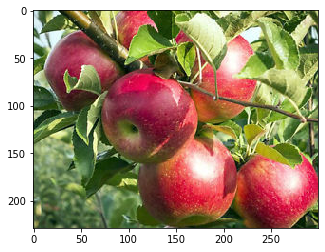

In [0]:
img_path = '/content/test_zip/test/apple_77.jpg'
img = cv2.imread(img_path)
show_img(img)

In [0]:
voc_labels = ('apple', 'orange', 'banana')
label_map = {k: v + 1 for v, k in enumerate(voc_labels)}
label_map['background'] = 0
rev_label_map = {v: k for k, v in label_map.items()}  # inverse mapping

distinct_colors = [(230, 25, 75), (255,165,0), (255, 225, 25), (0, 130, 200)] #red orange yellow blue
label_color_map = {k: distinct_colors[i] for i, k in enumerate(label_map.keys())}

In [0]:
def parse_annotation(annotation_path):
    tree = ET.parse(annotation_path)
    root = tree.getroot()

    boxes = list()
    labels = list()
    for object in root.iter('object'):

        difficult = int(object.find('difficult').text == '1')

        label = object.find('name').text.lower().strip()
        if label not in label_map:
            continue

        bbox = object.find('bndbox')
        xmin = int(bbox.find('xmin').text) - 1
        ymin = int(bbox.find('ymin').text) - 1
        xmax = int(bbox.find('xmax').text) - 1
        ymax = int(bbox.find('ymax').text) - 1

        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(label_map[label])

    return {'boxes': boxes, 'labels': labels}

In [0]:
class FruitDataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(Path(root).glob("**/*.jpg")))
        self.boxes = list(sorted(Path(root).glob("**/*.xml")))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.root[:-4], self.imgs[idx])
        box_path = os.path.join(self.root, self.root[:-4], self.boxes[idx])

        img = Image.open(img_path).convert("RGB")
        d = parse_annotation(box_path)
        boxes = d['boxes']
        labels = d['labels']
        num_objs = len(labels)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [0]:
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

### Finetuning a model & training

In [0]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_detection_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    num_classes = 4
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [0]:
from engine import train_one_epoch, evaluate

def main():
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    num_classes = 4

    dataset = FruitDataset('/content/train_zip', get_transform(train=True))
    dataset_test = FruitDataset('/content/test_zip', get_transform(train=False))

    indices = torch.randperm(len(dataset)).tolist()
    indices_test = torch.randperm(len(dataset_test)).tolist()
    dataset = torch.utils.data.Subset(dataset, indices)
    dataset_test = torch.utils.data.Subset(dataset_test, indices_test)

    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True, num_workers=4,
        collate_fn=utils.collate_fn)

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False, num_workers=4,
        collate_fn=utils.collate_fn)

    model = get_detection_model(num_classes)

    model.to(device)

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

    num_epochs = 10

    for epoch in range(num_epochs):
        warnings.filterwarnings('ignore')
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=30)
        lr_scheduler.step()
        #evaluate(model, data_loader_test, device=device)
        torch.save(model.state_dict(), '/content/saved/model') #saving model parameters

    print("That's it!")

    return model

In [0]:
model = main()

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth



Epoch: [0]  [  0/120]  eta: 0:04:08  lr: 0.000047  loss: 1.7691 (1.7691)  loss_classifier: 1.6336 (1.6336)  loss_box_reg: 0.1238 (0.1238)  loss_objectness: 0.0075 (0.0075)  loss_rpn_box_reg: 0.0042 (0.0042)  time: 2.0703  data: 0.5968  max mem: 1746
Epoch: [0]  [ 30/120]  eta: 0:00:36  lr: 0.001306  loss: 0.3540 (0.7965)  loss_classifier: 0.2234 (0.5857)  loss_box_reg: 0.1336 (0.1846)  loss_objectness: 0.0045 (0.0084)  loss_rpn_box_reg: 0.0091 (0.0178)  time: 0.3608  data: 0.0091  max mem: 4159
Epoch: [0]  [ 60/120]  eta: 0:00:23  lr: 0.002565  loss: 0.2679 (0.5549)  loss_classifier: 0.1191 (0.3650)  loss_box_reg: 0.1271 (0.1684)  loss_objectness: 0.0031 (0.0070)  loss_rpn_box_reg: 0.0086 (0.0144)  time: 0.3636  data: 0.0082  max mem: 4159
Epoch: [0]  [ 90/120]  eta: 0:00:11  lr: 0.003825  loss: 0.1777 (0.4539)  loss_classifier: 0.0755 (0.2800)  loss_box_reg: 0.0832 (0.1538)  loss_objectness: 0.0029 (0.0059)  loss_rpn_box_reg: 0.0143 (0.0141)  time: 0.3620  data: 0.0082  max mem: 4159

In [0]:
dataset_test = FruitDataset('/content/test_zip', get_transform(train=False))

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [0]:
evaluate(model, data_loader_test, device='cuda')

creating index...
index created!
Test:  [ 0/60]  eta: 0:00:15  model_time: 0.0871 (0.0871)  evaluator_time: 0.0053 (0.0053)  time: 0.2591  data: 0.1654  max mem: 4530
Test:  [59/60]  eta: 0:00:00  model_time: 0.0718 (0.0709)  evaluator_time: 0.0014 (0.0018)  time: 0.0778  data: 0.0043  max mem: 4530
Test: Total time: 0:00:04 (0.0828 s / it)
Averaged stats: model_time: 0.0718 (0.0709)  evaluator_time: 0.0014 (0.0018)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.655
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.938
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.795
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.679
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.664
 Average Recall     (AR) @[ IoU

###Showing Predictions

In [0]:
def plot_preds(img, bb_dict):
    font_scale = img.shape[0]/260
    thickness = round(img.shape[0]/150)
    font = cv2.FONT_HERSHEY_PLAIN

    boxes = bb_dict['boxes']
    boxes = boxes.cpu().detach().numpy() # detach from gradient graph

    labels = bb_dict['labels']
    labels = labels.cpu().detach().numpy()

    for i in range(len(labels)):

        obj = rev_label_map[labels[i]]
        color = label_color_map[obj]
        x1, y1, x2, y2 = boxes[i]

        x1 = int(x1)
        y1 = int(y1)

        img = cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness = thickness) # bounding box

        (text_width, text_height) = cv2.getTextSize(obj, font, fontScale=font_scale, thickness=2)[0]

        box_coords = ((x1, y1 - text_height - 2), (x1 + text_width + 2, y1))
        
        img = cv2.rectangle(img, box_coords[0], box_coords[1], color, cv2.FILLED)
        img = cv2.putText(img, obj, (x1, y1), font, fontScale=font_scale, color=(0, 0, 0), thickness=thickness-1)

    return img.get()

In [0]:
def predict(num):
    L = list(sorted(Path('/content/test_zip/test').glob("**/*.jpg")))
    ind = random.sample(range(len(L)), num)

    L = [L[i] for i in ind]
    for img_path in L:
        img = cv2.imread(str(img_path))[:,:,::-1]
        img_tensor = torch.from_numpy(img.astype('float32')/255).cuda().permute(2, 0, 1)
        img_tensor = img_tensor.unsqueeze(0)
        model.eval()
        predictions = model(img_tensor.cuda())

        conf_thresh = 0.6
        predictions = predictions[0]

        boxes = predictions['boxes'][(predictions['scores'] > conf_thresh)]
        labels = predictions['labels'][(predictions['scores'] > conf_thresh)]
        bb_dict = {}
        bb_dict['boxes'] = boxes
        bb_dict['labels'] = labels

        boxes_img = plot_preds(img, bb_dict)
        plt.figure()
        plt.imshow(boxes_img.astype('uint'));

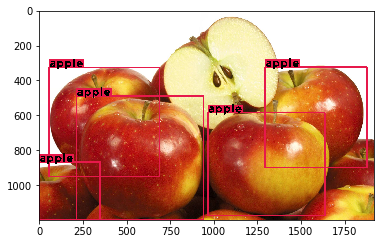

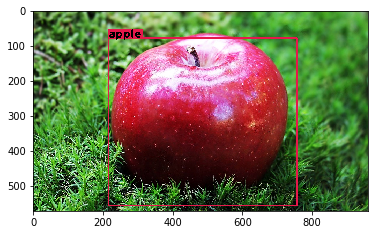

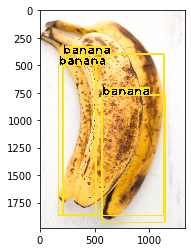

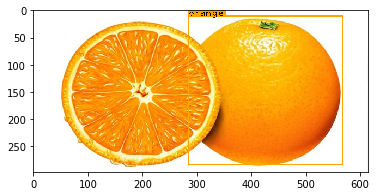

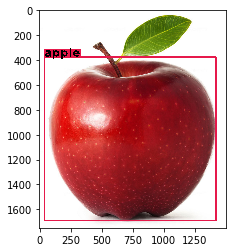

In [0]:
predict(5)